In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import multiprocess      as mp
import pandas            as pd

from libraries                         import utils
from pymatgen.analysis.phase_diagram   import PhaseDiagram
from pymatgen.entries.computed_entries import ComputedEntry
from os                                import path
from sklearn                           import model_selection
from sklearn.ensemble                  import RandomForestRegressor
from sklearn.neural_network            import MLPRegressor
from sklearn.model_selection           import ShuffleSplit

sns.set_theme()

Defining general output properties

In [2]:
linewidth      = 0.5
footnotesize   = 8
s_footnotesize = 10*0.8
eps_dpi        = 100
png_dpi        = 400
output_folder  = 'output/ternary_chalcohalides'
input_folder   = 'input/ternary_chalcohalides'

Selecting a functional

In [3]:
model_type = 'Convolutional Neural Network'
n_splits   = 20
n_fu       = 4

Initializing the objects for the limits

In [4]:
energy_limits    = utils.Limits()
band_gap_limits  = utils.Limits()
vbm_limits       = utils.Limits()
LEFT_abs_limits  = utils.Limits()
RIGHT_abs_limits = utils.Limits()

Setting the limits

In [5]:
energy_limits.upper = 0.1

Creating the grid

In [6]:
precision_search = 0.05

valid_xyz = None
x_grid = np.arange(0, 1+precision_search, precision_search)

xyz_grid = []
for i in x_grid:
    for j in x_grid:
        for k in x_grid:
            xyz_grid.append([i, j, k])
xyz_grid = np.array(xyz_grid)

# Iterations might be run from here

Defining target and range values

In [47]:
target = 'vbm'

Loading the data and converting into array

In [48]:
if valid_xyz is not None:
    xyz_grid = valid_xyz

temp_data = np.loadtxt(f'{input_folder}/{target}.txt')
X_ml = temp_data[:, :3]
y_ml = temp_data[:, 3]

if (target == 'energy_HSE06+LS') or (target == 'energy_PS'):
    y_ml /= n_fu  # By formula unit
    target_limits = energy_limits
    label_name    = r'$H_f$ (eV)'
    bar_name      = r'$\Delta H_f$ (eV/atom)'
    scale_factor  = 1e-1

elif target == 'band_gap':
    target_limits = band_gap_limits
    label_name    = r'$E_g$ (eV)'
    bar_name      = label_name
    scale_factor  = 1e-1

elif target == 'vbm':
    target_limits = vbm_limits
    label_name    = r'$VMB$ (eV)'
    bar_name      = label_name
    scale_factor  = 1e-1

elif target == 'RIGHT_abs':
    y_ml /= 1e4  # Change of units from cm to micro-m
    target_limits = RIGHT_abs_limits
    label_name    = r'$\alpha$ ($\mu\mathregular{m^{-1}}$)'
    bar_name      = label_name
    scale_factor  = 1

elif target == 'LEFT_abs':
    y_ml /= 1e4  # Change of units from cm to micro-m
    target_limits = LEFT_abs_limits
    label_name    = r'$\alpha$ ($\mu\mathregular{m^{-1}}$)'
    bar_name      = label_name
    scale_factor  = 1

Defining parameters of the models

In [49]:
def initialize_model(model_type):
    if model_type == 'Random Forest':
        parameters = {
            'n_estimators':      300,
            'criterion':         'squared_error',
            'max_depth':         None,
            'min_samples_leaf':  1,
            'min_samples_split': 2,
            'bootstrap':         True,
            'n_jobs':            mp.cpu_count()
        }
        model = RandomForestRegressor(**parameters)  # random_state=0

    elif model_type == 'Convolutional Neural Network':
        parameters = {
            'hidden_layer_sizes': (32, 64),
            'activation':         'relu',
            'solver':             'adam',
            'alpha':              0.05,
            'batch_size':         'auto',
            'learning_rate':      'constant',
            'max_iter':           10000,
            'momentum':           0.9
        }
        model = MLPRegressor(**parameters)  # random_state=0

    else:
        print('Model name not defined.')
    return model

## Test of one case

Testing one case

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


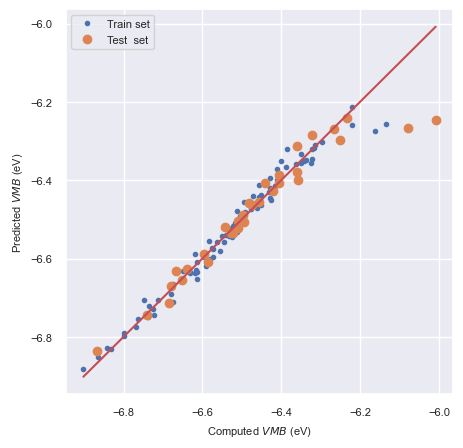

In [50]:
# Splitting the data

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_ml, y_ml)  # random_state=0

# Scaling

X_train, X_test, y_train, y_scaler = utils.xy_scaler(X_train, X_test, y_train)

# Fitting the model

model = initialize_model(model_type)
model.fit(X_train, y_train)

# Making predictions

y_temp = model.predict(X_train)
y_pred = model.predict(X_test)

# De-scaling

y_temp, y_train, y_pred = utils.y_descaler([y_temp, y_train, y_pred], y_scaler)

# Plotting the results

stack = np.hstack([y_temp, y_train, y_pred, y_test])
min_value = min(stack)
max_value = max(stack)

fig = plt.figure(figsize=(5, 5))

plt.xlabel(f'Computed {label_name}',  fontsize=footnotesize)
plt.ylabel(f'Predicted {label_name}', fontsize=footnotesize)

plt.plot(y_train, y_temp, '.', label='Train set')
plt.plot(y_test,  y_pred, 'o', label='Test  set')
plt.plot([min_value, max_value], [min_value, max_value], '-r')

plt.tick_params(axis='x', labelsize=footnotesize)
plt.tick_params(axis='y', labelsize=footnotesize)
plt.legend(loc='best', fontsize=footnotesize)
plt.savefig(f'{output_folder}/predictions_{target}.eps', dpi=eps_dpi, bbox_inches='tight')
plt.show()

## Computation of the cross validated loss

Implementing cross validation

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Train set MAE: 0.0120366440197367
Test  set MAE: 0.00750948324794957


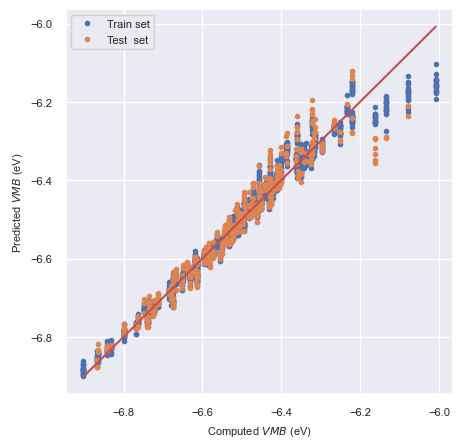

In [51]:
cv = ShuffleSplit(n_splits=n_splits, test_size=0.2)  # random_state=0

train_MAE = 0
test_MAE  = 0
y_temp_cv  = []
y_train_cv = []
y_pred_cv  = []
y_test_cv  = []
for i, (train_index, test_index) in enumerate(cv.split(X_ml)):
    # Scaling
    
    X_train, X_test, y_train, y_scaler = utils.xy_scaler(X_ml[train_index], X_ml[test_index], y_ml[train_index])
    y_test = y_ml[test_index]
    
    # Fitting the model
    
    model = initialize_model(model_type)
    model.fit(X_train, y_train)

    # Making predictions

    y_temp = model.predict(X_train)
    y_pred = model.predict(X_test)

    # De-scaling

    y_temp, y_train, y_pred = utils.y_descaler([y_temp, y_train, y_pred], y_scaler)
    
    # Appending data
    
    train_MAE += np.linalg.norm(y_train - y_temp) / len(test_index)
    test_MAE  += np.linalg.norm(y_pred  - y_test) / len(test_index)
    y_temp_cv.append(y_temp)
    y_train_cv.append(y_train)
    y_pred_cv.append(y_pred)
    y_test_cv.append(y_test)

print(f'Train set MAE: {train_MAE / n_splits}')
print(f'Test  set MAE: {test_MAE  / n_splits}')

y_temp  = np.concatenate(y_temp_cv)
y_train = np.concatenate(y_train_cv)
y_pred  = np.concatenate(y_pred_cv)
y_test  = np.concatenate(y_test_cv)

# Plotting the results

stack = np.hstack([y_temp, y_train, y_pred, y_test])
min_value = min(stack)
max_value = max(stack)

fig = plt.figure(figsize=(5, 5))

plt.xlabel(f'Computed {label_name}',  fontsize=footnotesize)
plt.ylabel(f'Predicted {label_name}', fontsize=footnotesize)

plt.plot(y_train, y_temp, '.', label='Train set')
plt.plot(y_test,  y_pred, '.', label='Test  set')
plt.plot([min_value, max_value], [min_value, max_value], '-r')

plt.tick_params(axis='x', labelsize=footnotesize)
plt.tick_params(axis='y', labelsize=footnotesize)
plt.legend(loc='best', fontsize=footnotesize)
plt.savefig(f'{output_folder}/predictions_{target}_cv.eps', dpi=eps_dpi, bbox_inches='tight')
plt.show()

## Computation of the learning curves

Obtaining learning metrics

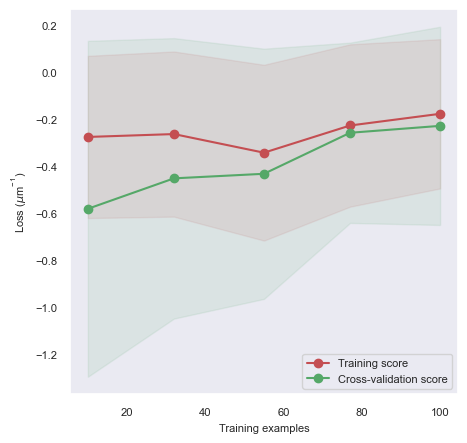

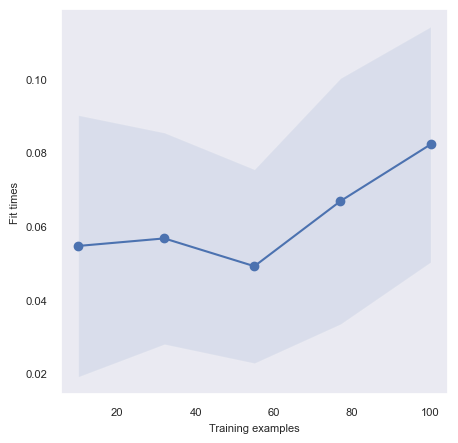

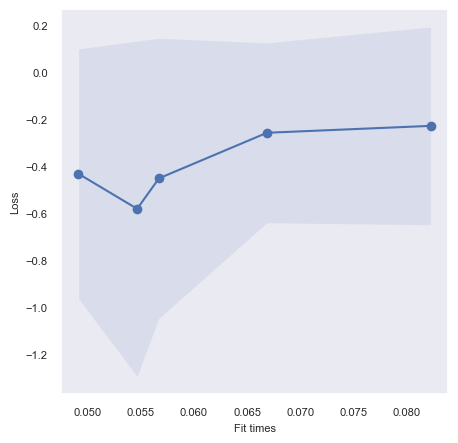

In [52]:
figure_name = f'{output_folder}/Metrics_{target}.png'
scoring     = 'neg_mean_squared_error'

train_sizes, train_scores, test_scores = utils.plot_learning_curve(
    model,
    figure_name,
    X_ml,
    y_ml,
    cv=cv,
    scoring=scoring,
    n_jobs=mp.cpu_count(),
    dpi=png_dpi,
)

# Grid search

Computing the predictions

In [53]:
# Scaling

X_train, X_test, y_train, y_scaler = utils.xy_scaler(X_ml, xyz_grid, y_ml)

# Fitting the model

model.fit(X_train, y_train)

# Making predictions and de-standardizing

xyz_pred = model.predict(X_test)
xyz_pred = utils.y_descaler([xyz_pred], y_scaler)
xyz_pred = np.ravel(xyz_pred)

Specific composition (BI0.3 Sb0.7 Se I)

In [54]:
# Scaling

synthesized_prediction_composition = [0.3, 0, 1]
_, X_test_temp, _, _ = utils.xy_scaler(X_ml, [synthesized_prediction_composition], y_ml)

# Making predictions and de-standardizing

xyz_pred_temp = model.predict(X_test_temp)
synthesized_prediction = utils.y_descaler([xyz_pred_temp], y_scaler)[0]
synthesized_prediction

array([-6.17620209])

In [55]:
# Scaling

synthesized_prediction_composition = [1, 0, 1]
_, X_test_temp, _, _ = utils.xy_scaler(X_ml, [synthesized_prediction_composition], y_ml)

# Making predictions and de-standardizing

xyz_pred_temp = model.predict(X_test_temp)
synthesized_prediction = utils.y_descaler([xyz_pred_temp], y_scaler)[0]
synthesized_prediction

array([-6.27031009])

Computing energy calculations, if required

In [56]:
if (target == 'energy_HSE06+LS') or (target == 'energy_PS'):
    if path.exists(f'{input_folder}/energetic_stability.txt'):
        results = np.loadtxt(f'{input_folder}/energetic_stability.txt')
    else:
        # All energies in eV/fu, computed at PBEs level of theory
        # The convex hull routine of pymatgen converts this into eV/atom
        
        # Corrections are not considered
        correction = 0
        
        # DFT energies (eV/fu)
        # FROM VCA
        
        if target == 'energy_HSE06+LS':
            energies_convexhull = {
                'Bi': -5.399813,
                'Sb': -5.433284,
                'S':  -5.412458,
                'Se': -4.645566,
                'I':  -2.312596,
                'Br': -2.432998,
                'Bi2S3':  -28.362355,
                'Bi2Se3': -26.452513,
                'Sb2S3':  -28.310133,
                'Sb2Se3': -26.176395,
                'BiI3':   -14.189628,
                'BiBr3':  -15.614426,
                'SbI3':   -13.827897,
                'SbBr3':  -15.187721
            }
        elif target == 'energy_PS':
            energies_convexhull = {
                'Bi': -4.289179,
                'Sb': -4.559573,
                'S':  -4.383646,
                'Se': -3.850400,
                'I':  -1.730931,
                'Br': -1.870427,
                'Bi2S3':  -23.684051,
                'Bi2Se3': -22.044146,
                'Sb2S3':  -23.721411,
                'Sb2Se3': -21.962036,
                'BiI3':   -11.337934,
                'BiBr3':  -12.765129,
                'SbI3':   -11.155779,
                'SbBr3':  -12.345123
            }
        
        my_entries = []
        for element in energies_convexhull:
            # Get the energy of the element
            energy = energies_convexhull[element]

            # Generate the temporal entry
            entry = ComputedEntry(element, energy, correction)  # Correction are set all to zero

            # Append the temporal entry
            my_entries.append(entry)
        
        # Generate convex-hull
        pd = PhaseDiagram(my_entries)
        
        # Compare every prediction with the convex-hull
        results = []
        for index in range(len(xyz_grid)):
            # Extract the composition for the current prediciton
            x, y, z = xyz_grid[index]
            
            # Generate a formula with its name for generating an entry
            new_element = f'Bi{x}Sb{1-x}S{y}Se{1-y}I{z}Br{1-z}'
            
            # Extract the predicted energy (in eV/fu)
            new_energy = xyz_pred[index]
            
            # Define a new entry
            new_entry = ComputedEntry(new_element, new_energy, correction)
            
            # Calculate the energy above the convex-hull (in eV/atom)
            decomp, e_above_hull = pd.get_decomp_and_phase_separation_energy(new_entry)
            
            # Append the result
            results.append([x, y, z, e_above_hull])

        results = np.array(results, dtype=float)
        #np.savetxt(f'{input_folder}/energetic_stability.txt', results)

    # Getting grid and predictions

    xyz_grid = results[:, :3]
    xyz_pred = results[:, 3]

In [57]:
valid_xyz  = xyz_grid.copy()
valid_pred = xyz_pred.copy()

if target_limits.upper is not None:
    indexes = np.where(target_limits.upper >= valid_pred)[0]
    valid_xyz  = valid_xyz[indexes]
    valid_pred = valid_pred[indexes]

if target_limits.lower is not None:
    indexes = np.where(target_limits.lower <= valid_pred)[0]
    valid_xyz  = valid_xyz[indexes]
    valid_pred = valid_pred[indexes]

In [58]:
min_idx = np.argmin(valid_pred)
max_idx = np.argmax(valid_pred)

print(valid_pred[min_idx], valid_pred[max_idx])
print(valid_xyz[min_idx], valid_xyz[max_idx])

-6.8776774574992325 -6.173995368191189
[1.  1.  0.3] [0. 0. 1.]


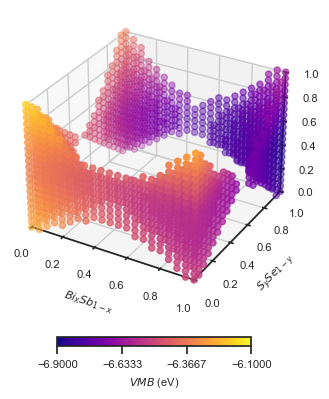

In [59]:
sns.set_theme(style='white')

fig = plt.figure(figsize=(5, 5))
ax  = plt.axes(projection='3d')

# Setting minimum and maximum values for the colorbar
vmin = np.floor(np.min(valid_pred) / scale_factor) * scale_factor
vmax = np.ceil(np.max(valid_pred)  / scale_factor) * scale_factor

# Plot synthesized composition
sc = ax.scatter(synthesized_prediction_composition[0],
                synthesized_prediction_composition[1],
                synthesized_prediction_composition[2],
                c='k',
                marker='*')

# Plotting valid points
sc = ax.scatter(valid_xyz[:, 0],
                valid_xyz[:, 1],
                valid_xyz[:, 2],
                c=valid_pred,
                vmin=vmin, vmax=vmax,
                marker='o', cmap='plasma')

# Bar
cbar = fig.colorbar(sc, orientation='horizontal', location='bottom',
                    pad=0.1, shrink=0.5, ticks=np.linspace(vmin, vmax, 4))

# Defining bar
cbar.ax.tick_params(labelsize=footnotesize)
cbar.set_label(bar_name, fontsize=footnotesize)

# Setting labels
ax.set_xlabel(r'$Bi_x Sb_{1-x}$',  fontsize=footnotesize)
ax.set_ylabel(r'$S_y Se_{1-y}$',  fontsize=footnotesize)
ax.set_zlabel(r'$I_z Br_{1-z}$',  fontsize=footnotesize)

# Setting number to scale
ax.tick_params(axis='x', labelsize=footnotesize)
ax.tick_params(axis='y', labelsize=footnotesize)
ax.tick_params(axis='z', labelsize=footnotesize)

# Setting limits
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

# Saving the figure
plt.savefig(f'{output_folder}/Valid_region_{target}.pdf')
plt.show()

sns.set_theme()

In [60]:
results = np.concatenate([valid_xyz, valid_pred.reshape(-1, 1)], axis=1)
np.savetxt(f'{input_folder}/results_vbm.txt', results)
results

array([[ 0.        ,  0.        ,  0.        , -6.25762875],
       [ 0.        ,  0.        ,  0.05      , -6.26903786],
       [ 0.        ,  0.        ,  0.1       , -6.28180814],
       ...,
       [ 1.        ,  1.        ,  0.9       , -6.68384275],
       [ 1.        ,  1.        ,  0.95      , -6.65614252],
       [ 1.        ,  1.        ,  1.        , -6.62966501]],
      shape=(1804, 4))

In [34]:
if (target == 'energy_HSE06+LS') or (target == 'energy_PS'):
    # Extract the composition for the current prediciton
    x, y, z = synthesized_prediction_composition

    # Generate a formula with its name for generating an entry
    new_element = f'Bi{x}Sb{1-x}S{y}Se{1-y}I{z}Br{1-z}'

    # Extract the predicted energy (in eV/fu)
    new_energy = synthesized_prediction[0]

    # Define a new entry
    new_entry = ComputedEntry(new_element, new_energy, correction)

    # Calculate the energy above the convex-hull (in eV/atom)
    decomp, e_above_hull = pd.get_decomp_and_phase_separation_energy(new_entry)

    print(synthesized_prediction_composition, e_above_hull)